# Analysis of Missouri Births: 2011-2021
Data Source: Centers for Disease Control and Prevention  
http://wonder.cdc.gov/natality-current.html

---
### Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import csv
from scipy import stats 

filename = "Birth_Data_Natality_2011-2021.txt"

# read file contents  
with open(filename) as f:
    reader = csv.reader(f, delimiter="\t")
    d = list(reader)    

# use first row as headers    
header_row = d[0]
header_row = [i.replace(" ", "_") for i in header_row]

# create dataframe from list
births_df = pd.DataFrame(d[1:], columns=header_row)

# delete note column and rows with empty year
births_df = births_df.drop(births_df.columns[0], axis=1)
births_df = births_df.dropna(axis=0, subset=['Year'])

# update datatype
births_df['Births'] = births_df['Births'].astype(int)

# add year-month columns
month_pad = [i.zfill(2) for i in births_df["Month_Code"]]
births_df['Year_Month'] = births_df["Year"] + "-" + month_pad
births_df['Year_Month_Date'] = births_df["Year"] + "-" + month_pad + "-01" 
births_df['Year_Month_Date'] = pd.to_datetime(births_df['Year_Month_Date'])

print(births_df)

# save to csv
births_df.to_csv('Birth_Data_Output.csv')

                         County County_Code            Tobacco_Use   
0              Boone County, MO       29019                    Yes  \
1              Boone County, MO       29019                    Yes   
2              Boone County, MO       29019                    Yes   
3              Boone County, MO       29019                    Yes   
4              Boone County, MO       29019                    Yes   
...                         ...         ...                    ...   
5402  Unidentified Counties, MO       29999  Unknown or Not Stated   
5403  Unidentified Counties, MO       29999  Unknown or Not Stated   
5404  Unidentified Counties, MO       29999  Unknown or Not Stated   
5405  Unidentified Counties, MO       29999  Unknown or Not Stated   
5406  Unidentified Counties, MO       29999  Unknown or Not Stated   

     Tobacco_Use_Code  Year Year_Code     Month Month_Code  Gender   
0                   1  2011      2011   January          1  Female  \
1                  

---
### Exploratory Data Analysis

In [2]:
line_break = "--------------------------------------------"

print(births_df.describe())
print(line_break)

print(births_df.County.value_counts())
print(line_break)

print(births_df.Tobacco_Use.value_counts())
print(line_break)

print(births_df.Year_Month.value_counts())
print(line_break)

print("Earliest date:", births_df.Year_Month.min())
print("Latest date:",births_df.Year_Month.max())

            Births                Year_Month_Date
count  5407.000000                           5407
mean    148.137414  2016-05-13 22:55:01.054188800
min      10.000000            2011-01-01 00:00:00
25%      22.000000            2013-09-01 00:00:00
50%      63.000000            2016-05-01 00:00:00
75%     158.000000            2019-01-01 00:00:00
max    1210.000000            2021-12-01 00:00:00
std     225.776257                            NaN
--------------------------------------------
County
Unidentified Counties, MO    686
St. Louis County, MO         559
Jackson County, MO           535
Greene County, MO            526
St. Louis city, MO           519
Jefferson County, MO         516
St. Charles County, MO       483
Clay County, MO              470
Jasper County, MO            436
Boone County, MO             397
Franklin County, MO          280
Name: count, dtype: int64
--------------------------------------------
Tobacco_Use
No                       2832
Yes                   

---
### Charts

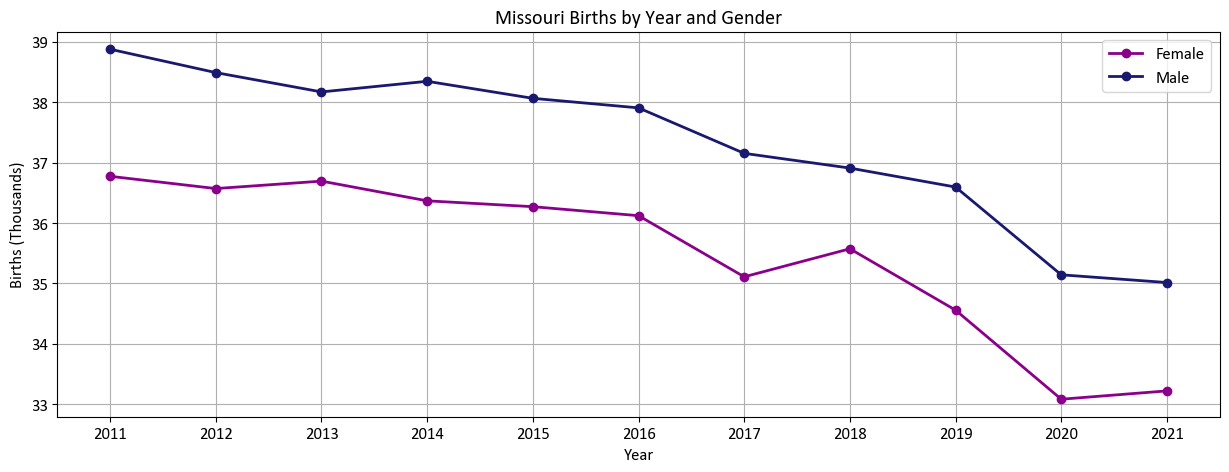

In [3]:
# births by gender per year 

sum_df = pd.DataFrame()
sum_df = births_df.groupby(['Year','Gender'], as_index=False).agg({"Births": "sum"})

maledf = sum_df[sum_df['Gender'] == "Male"]
femaledf = sum_df[sum_df['Gender'] == "Female"]

plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "calibri"
plt.rcParams["figure.figsize"] = [15, 5]

plt.plot(femaledf["Year"], femaledf["Births"].div(1000), marker='o', color='darkmagenta', linewidth=2)
plt.plot(maledf["Year"], maledf["Births"].div(1000), marker='o', color='midnightblue', linewidth=2)

plt.title("Missouri Births by Year and Gender")
plt.ylabel("Births (Thousands)")
plt.xlabel("Year") 
plt.legend(['Female', 'Male'])
plt.grid()
plt.savefig('charts/MO_Births_Gender_Trend.png')
plt.show()

Average births per month: 6068.022727272727
Greatest births per month: 7092
Top 10 Months by Birth Count:
   Year_Month_Date  Births
7       2011-08-01    7092
19      2012-08-01    6928
31      2013-08-01    6802
67      2016-08-01    6777
18      2012-07-01    6755
30      2013-07-01    6750
54      2015-07-01    6716
91      2018-08-01    6669
43      2014-08-01    6660
5       2011-06-01    6655


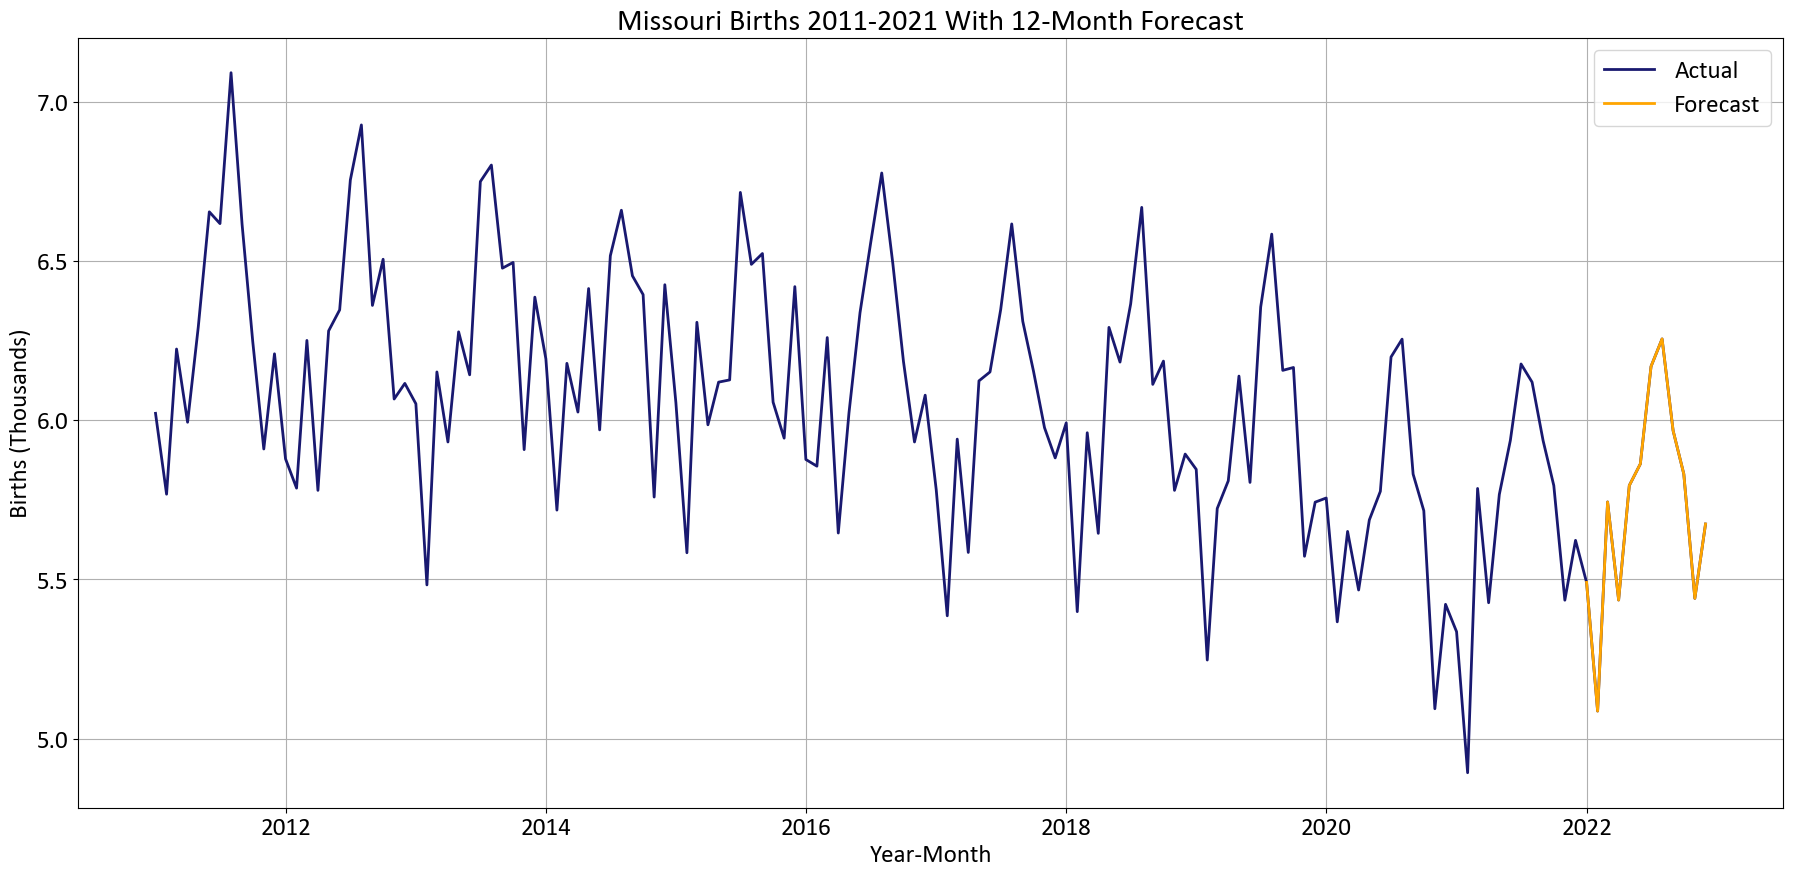

In [20]:
# births per month with 12 month forecast
import statsmodels.api as sm

sum_df = pd.DataFrame()
sum_df = births_df.groupby(['Year_Month_Date'], as_index=False).agg({"Births": "sum"})
sum_df['Row'] = sum_df.reset_index().index
max_row = sum_df['Row'].max()
print("Average births per month:", sum_df.Births.mean())
print("Greatest births per month:", sum_df.Births.max())
print("Top 10 Months by Birth Count:")
print(sum_df.nlargest(10, 'Births')[['Year_Month_Date','Births']])

# seasonal arima modal to forecast future months
model = sm.tsa.statespace.SARIMAX(sum_df['Births'],order=(0,1,0), seasonal_order=(1,1,1,12))
ARIMAresult = model.fit()
#print(ARIMAresult.summary())

# create dataframe for forecast results
fdf = pd.DataFrame()
fdf['forecast_data'] = ARIMAresult.predict(start=(max_row+1), end=(max_row+12), dynamic= True)  
#fdf [['forecast_data']]. plot (figsize= (12,8))

# create new dataframe for forecast results with months
dic = {'Year_Month_Date':['2022-01-01 00:00:00', '2022-02-01 00:00:00', '2022-03-01 00:00:00', 
                           '2022-04-01 00:00:00', '2022-05-01 00:00:00', '2022-06-01 00:00:00',
                           '2022-07-01 00:00:00', '2022-08-01 00:00:00', '2022-09-01 00:00:00', 
                           '2022-10-01 00:00:00', '2022-11-01 00:00:00', '2022-12-01 00:00:00' ],
        'Births':[fdf['forecast_data'].iloc[0], fdf['forecast_data'].iloc[1], fdf['forecast_data'].iloc[2],
                  fdf['forecast_data'].iloc[3], fdf['forecast_data'].iloc[4], fdf['forecast_data'].iloc[5], 
                  fdf['forecast_data'].iloc[6], fdf['forecast_data'].iloc[7], fdf['forecast_data'].iloc[8],
                  fdf['forecast_data'].iloc[9], fdf['forecast_data'].iloc[10], fdf['forecast_data'].iloc[11] ]
        }
f_df = pd.DataFrame(dic)
f_df['Year_Month_Date'] = pd.to_datetime(f_df['Year_Month_Date'])

# combine actuals with forecast
df = pd.concat([sum_df, f_df], ignore_index = True)
df.reset_index()
df['Row'] = df.reset_index().index

plt.rcParams["figure.figsize"] = [22, 10]
plt.rcParams["font.size"] = 18
plt.rcParams["font.family"] = "calibri"

# plot the actuals with forecast, overlay forecast with orange line
plt.plot(df["Year_Month_Date"], df["Births"].div(1000), color='midnightblue', linewidth=2)
plt.plot(f_df["Year_Month_Date"], f_df["Births"].div(1000), color='orange', linestyle='solid', linewidth=2)

plt.title("Missouri Births 2011-2021 With 12-Month Forecast")
plt.ylabel("Births (Thousands)")
plt.xlabel("Year-Month")
plt.legend(['Actual', 'Forecast'])
plt.grid()
plt.savefig('charts/MO_Births_Month+Forecast.png')
plt.show()

                       County  Births
2         Franklin County, MO    8803
5           Jasper County, MO   17179
0            Boone County, MO   21586
6        Jefferson County, MO   27775
1             Clay County, MO   32842
3           Greene County, MO   37681
9          St. Louis city, MO   46981
7      St. Charles County, MO   47714
4          Jackson County, MO  100633
8        St. Louis County, MO  124173
10  Unidentified Counties, MO  335612


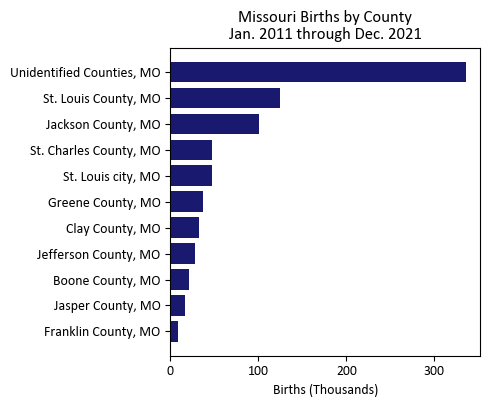

In [21]:
# births per county

sum_df = pd.DataFrame()
sum_df = births_df.groupby(['County'], as_index=False).agg({"Births": "sum"})
sum_df = sum_df.sort_values('Births')
print(sum_df)

plt.rcParams["font.size"] = 10
plt.rcParams["font.family"] = "calibri"
plt.rcParams["figure.figsize"] = [4, 4]
plt.barh(sum_df["County"], sum_df["Births"].div(1000), color='midnightblue')
plt.title("Missouri Births by County\nJan. 2011 through Dec. 2021")
plt.xlabel("Births (Thousands)") 
plt.savefig('charts/MO_Births_County.png', bbox_inches='tight', pad_inches=0.25)
plt.show()

                       County Tobacco_Use  Births   Total   Percent
17       St. Louis County, MO         Yes    9081  123709  0.073406
15     St. Charles County, MO         Yes    3665   47714  0.076812
1            Boone County, MO         Yes    1668   21586  0.077272
3             Clay County, MO         Yes    3165   32842  0.096371
5         Franklin County, MO         Yes    1041    8803  0.118255
19         St. Louis city, MO         Yes    5615   46971  0.119542
9          Jackson County, MO         Yes   12229  100546  0.121626
11          Jasper County, MO         Yes    2371   17179  0.138017
7           Greene County, MO         Yes    6314   37681  0.167565
13       Jefferson County, MO         Yes    4975   27775  0.179118
21  Unidentified Counties, MO         Yes   67449  333221  0.202415
20  Unidentified Counties, MO          No  265772  333221  0.797585
12       Jefferson County, MO          No   22800   27775  0.820882
6           Greene County, MO          No   3136

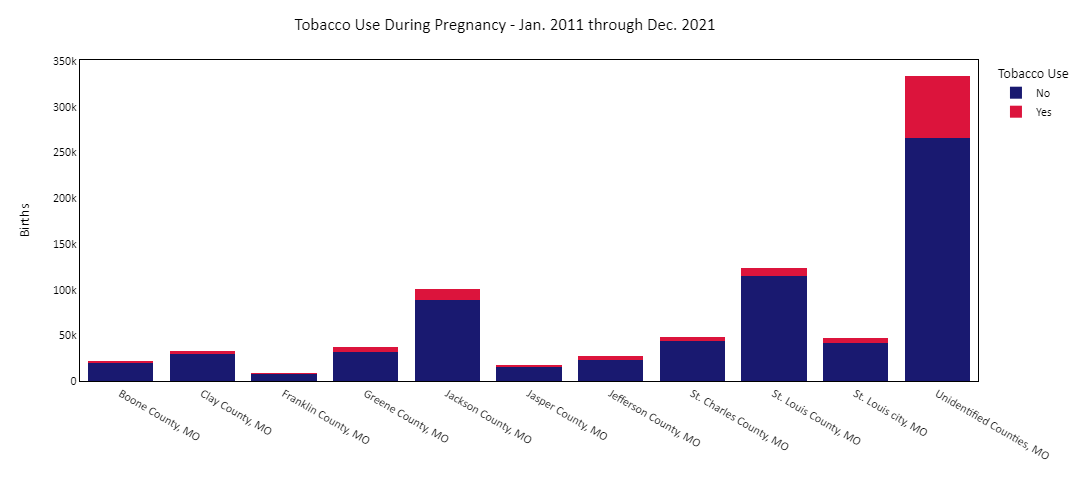

In [27]:
# tobacco use during pregnancy by county

df = births_df[births_df['Tobacco_Use'] != 'Unknown or Not Stated']
df = df.sort_values(by=['County','Tobacco_Use'])

dfp = df.groupby(['County','Tobacco_Use'], as_index=False).agg({"Births": "sum"})
dfp['Total'] = dfp['Births'].groupby(dfp['County']).transform('sum')
dfp['Percent'] = dfp['Births']/dfp['Total']
dfp = dfp.sort_values(by=['Percent'])
print(dfp)
    
fig = px.histogram(df, x="County", y="Births", color='Tobacco_Use', height=500, width=800,
                   barmode='stack', color_discrete_sequence=['midnightblue','crimson'],
                   labels={
                     "County": "",
                     "Tobacco_Use": "Tobacco Use"
                  })
fig.update_layout(title_text='Tobacco Use During Pregnancy - Jan. 2011 through Dec. 2021', title_x=0.466)
fig.update_layout(yaxis_title="Births")
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
fig.update_layout(font_family="Calibri", font_color="black")

fig.update_xaxes(showline=True,
         linewidth=1,
         linecolor='black',
         mirror=True)
fig.update_yaxes(showline=True,
         linewidth=1,
         linecolor='black',
         mirror=True)
fig.write_image("charts/MO_Birth_County_Tobacco.png")
fig.show()

Citation:  
Centers for Disease Control and Prevention, National Center for Health Statistics. National Vital Statistics System, Natality on CDC WONDER Online Database. Data are from the Natality Records 2007-2021, as compiled from data provided by the 57 vital statistics jurisdictions through the Vital Statistics Cooperative Program. Accessed at http://wonder.cdc.gov/natality-current.html on Apr 23, 2023 4:00:14 PM  

Caveats:
1. 'Missing County' appears when county data is not available for a certain year. This occurs because the county did not meet minimum population standards and thus the data for the county was recoded to the "Unidentified Counties" category for the state of the county. More information: http://wonder.cdc.gov/wonder/help/Natality.html#Locations.

2. 'Suppressed' appears when the data do not meet the criteria for confidentiality constraints. More information: http://wonder.cdc.gov/wonder/help/Natality.html# Assurance of Confidentiality.

3. Each birth record represents one liveborn infant.

4. County-level data are shown only for counties with populations of 100,000 persons or more. Within each state, data for all counties with fewer than 100,000 persons are combined together under the label "Unidentified Counties".

5. About Maternal Tobacco Use data: Maternal Tobacco Use data have been recoded to "Not Reported" for births to mothers residing in a reporting area that used the 1989 U.S. Standard Certificate of Live Birth or did not report Tobacco Use in the specified data year. All reporting areas, except California, routinely collect information on Maternal Tobacco Use, but information from the 2003 revision of the birth certificate is not comparable to the information based on the earlier certificate. The following reporting areas have Maternal Tobacco Use data coded to "Not Reported": Alabama 2007-2013; Alaska 2007-2012; Arizona 2007-2013; Arkansas 2007-2013; Connecticut 2007-2015; District of Columbia 2007-2009; Florida 2007-2010; Georgia 2007-2010; Hawaii 2007-2014; Illinois 2007-2009; Louisiana 2007-2010; Maine 2007-2013; Maryland 2007-2009; Massachusetts 2007-2011; Michigan 2007-2013; Minnesota 2007-2011; Mississippi 2007-2012; Missouri 2007-2009; Montana 2007; Nevada 2007-2009; New Jersey 2007-2015; New Mexico 2007; New York (only counties comprising New York City) 2007; North Carolina 2007-2010; Oklahoma 2007-2009; Oregon 2007; Rhode Island 2007-2014; Utah 2007-2008; Virginia 2007-2012; West Virginia 2007-2013; Wisconsin 2007-2010. Note the change from preceding years: Natality data for years 2003-2006 in CDC WONDER reported Tobacco Use data as "Not Reported" for the reporting areas that had adopted the 2003 U.S. Standard Certificate of Live Birth. 

6. As a result of population changes the following counties do not have data available for all years. Before 2014 the data for the following counties was recoded to the "Unidentified Counties" category within the state of the county because they did not meet minimum population standards. Houston County, AL (01069); Navajo County, AZ (04017); Faulkner County, AR (05045); Saline County, AR (05125); Bartow County, GA (13015); Carroll County, GA (13045); Columbia County, GA (13073); Coweta County, GA (13077); Douglas County, GA (13097); Fayette County, GA (13113); Forsyth County, GA (13117); Lowndes County, GA (13185); Paulding County, GA (13223); Whitfield County, GA (13313); Bonneville County, ID (16019); DeKalb County, IL (17037); Kendall County, IL (17093); Clark County, IN (18019); Douglas County, KS (20045); Boone County, KY (21015); Hardin County, KY (21093); Warren County, KY (21227); Ascension Parish, LA (22005); Bossier Parish, LA (22015); Livingston Parish, LA (22063); Cecil County, MD (24015); St. Mary's County, MD (24037); Scott County, MN (27139); Wright County, MN (27171); Franklin County, MO (29071); Missoula County, MT (30063); Sandoval County, NM (35043); Tompkins County, NY (36109); Brunswick County, NC (37019); Craven County, NC (37049); Harnett County, NC (37085); Henderson County, NC (37089); Miami County, OH (39109); Canadian County, OK (40017); Adams County, PA (42001); Dorchester County, SC (45035); Pennington County, SD (46103); Wilson County, TN (47189); Comal County, TX (48091); Guadalupe County, TX (48187); Hays County, TX (48209); Kaufman County, TX (48257); Parker County, TX (48367); Cache County, UT (49005); Washington County, UT (49053); Spotsylvania County, VA (51177); Stafford County, VA (51179); Cowlitz County, WA (53015); Berkeley County, WV (54003); Fond du Lac County, WI (55039); Walworth County, WI (55127). After 2013 the data for the following counties was recoded to the "Unidentified Counties" category within the state of the county because they did not meet minimum population standards. Cape May County, NJ (34009); Portsmouth city, VA (51740). 
    
7. The independent city of St. Louis, Missouri (FIPS code 29510) is reported separately from St. Louis County (FIPS code 29189).